# Boston Housing Dataset

### Предметная область
Недвижимость в пригородах Бостона

### Источник данных
Набор данных Boston Housing  
https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data

**Первоисточник:**  
Харрисон, Д. и Рубинфельд, Д. Л. «Гедонистические цены и спрос на чистый воздух»  
J. Environ. Economics & Management, т. 5, стр. 81–102, 1978 г.

### Характер данных
Реальные данные

#  ИНФОРМАЦИЯ ОБ АТРИБУТАХ ДАТАСЕТА BOSTON HOUSING

## Входные данные (14 атрибутов):

| № | Атрибут | Описание | Единицы измерения |
|---|---------|----------|-------------------|
| 1 | **CRIM** | Уровень преступности на душу населения в городе | случаи на душу населения |
| 2 | **ZN** | Доля жилых земель, отнесенных к категории участков площадью более 25 000 кв. футов | % |
| 3 | **INDUS** | Доля нерозничных коммерческих акров в городе | % |
| 4 | **CHAS** | Фиктивная переменная реки Чарльз (1 - если участок граничит с рекой; 0 - в противном случае) | бинарная (0/1) |
| 5 | **NOX** | Концентрация оксидов азота | частиц на 10 миллионов |
| 6 | **RM** | Среднее количество комнат в жилище | комнат |
| 7 | **AGE** | Доля единиц жилья, занимаемых владельцами, построенных до 1940 года | % |
| 8 | **DIS** | Взвешенные расстояния до пяти бостонских центров занятости | условные единицы |
| 9 | **RAD** | Индекс доступности к радиальным магистралям | индекс |
| 10 | **TAX** | Ставка налога на имущество с полной стоимостью | $ за 10 000 стоимости |
| 11 | **PTRATIO** | Соотношение учеников и учителей по городам | учеников на учителя |
| 12 | **B** | Результат уравнения B = 1000(Bk - 0,63)², где Bk — доля чернокожих по городам | расчётный показатель |
| 13 | **LSTAT** | Процент населения с низким статусом | % |
| 14 | **MEDV** | Медианная стоимость домов, занимаемых владельцами | тысячи долларов США |

---

##  Целевая переменная:
- **MEDV** - Медианная стоимость домов (тыс. $)

##  Типы данных:
- **Все атрибуты** представлены в числовом виде
- **CHAS** - единственная категориальная (бинарная) переменная
- **Остальные атрибуты** - непрерывные числовые переменные

---

###  Примечание:
Датасет содержит информацию о 506 районах Бостона и используется для прогнозирования стоимости жилья на основе различных социально-экономических и физических характеристик.

##  Выполнение работы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('boston.csv')

## Добавление нового атрибута 
Добавим атрибут "PRICE_PER_ROOM" - цена за комнату. Вычесляеться как отшошение медианной стоимости домов на среднее количество комнат в жилище

In [3]:
df['PRICE_PER_ROOM'] = df['MEDV'] / df['RM']

## Удаление выбросов и дублей, обработка пропущенных значений

**Находим пропущенные значения**

In [8]:
print("Пропущенные значения:")
print(df.isnull().sum())
print("\nВсего пропущенных занчений:", df.isnull().sum().sum())

Пропущенные значения:
CRIM              0
ZN                0
INDUS             0
CHAS              0
NOX               0
RM                0
AGE               0
DIS               0
RAD               0
TAX               0
PTRATIO           0
B                 0
LSTAT             0
MEDV              0
PRICE_PER_ROOM    0
dtype: int64

Всего пропущенных занчений: 0


**Проверка на дубликаты**

In [9]:
print(f"\nКоличество дубликатов: {df.duplicated().sum()}")


Количество дубликатов: 0


**Обработка выбросов**

Для начала определим количество выбросов

In [10]:
outlier_summary = []
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[column][(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_percent = len(outliers) / len(df) * 100
    
    outlier_summary.append({
        'Атрибут': column,
        'Выбросы (кол-во)': len(outliers),
        'Выбросы (%)': f'{outlier_percent:.2f}%',
    })

outlier_df = pd.DataFrame(outlier_summary)
print("Сводка по выбросам:")
print(outlier_df)

Сводка по выбросам:
           Атрибут  Выбросы (кол-во) Выбросы (%)
0             CRIM                66      13.04%
1               ZN                68      13.44%
2            INDUS                 0       0.00%
3             CHAS                35       6.92%
4              NOX                 0       0.00%
5               RM                30       5.93%
6              AGE                 0       0.00%
7              DIS                 5       0.99%
8              RAD                 0       0.00%
9              TAX                 0       0.00%
10         PTRATIO                15       2.96%
11               B                77      15.22%
12           LSTAT                 7       1.38%
13            MEDV                40       7.91%
14  PRICE_PER_ROOM                30       5.93%


**Обрабатываем выбросы заменяя выбросы граничными значениями**

In [11]:
num_columns = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Обрабатываем {len(num_columns)} числовых атрибутов...")

for col in num_columns:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        
        print(f"  {col}: границы [{lower_bound:.2f}, {upper_bound:.2f}]")

print("Выбросы обработаны")

Обрабатываем 15 числовых атрибутов...
  CRIM: границы [-5.31, 9.07]
  ZN: границы [-18.75, 31.25]
  INDUS: границы [-14.18, 37.47]
  CHAS: границы [0.00, 0.00]
  NOX: границы [0.19, 0.89]
  RM: границы [4.78, 7.73]
  AGE: границы [-28.55, 167.65]
  DIS: границы [-2.53, 9.82]
  RAD: границы [-26.00, 54.00]
  TAX: границы [-301.50, 1246.50]
  PTRATIO: границы [13.20, 24.40]
  B: границы [344.11, 427.50]
  LSTAT: границы [-8.06, 31.96]
  MEDV: границы [5.06, 36.96]
  PRICE_PER_ROOM: границы [1.10, 5.80]
Выбросы обработаны


## Построение графиков зависимости

Выберем ключевые переменные для анализа и пострим по ним графики

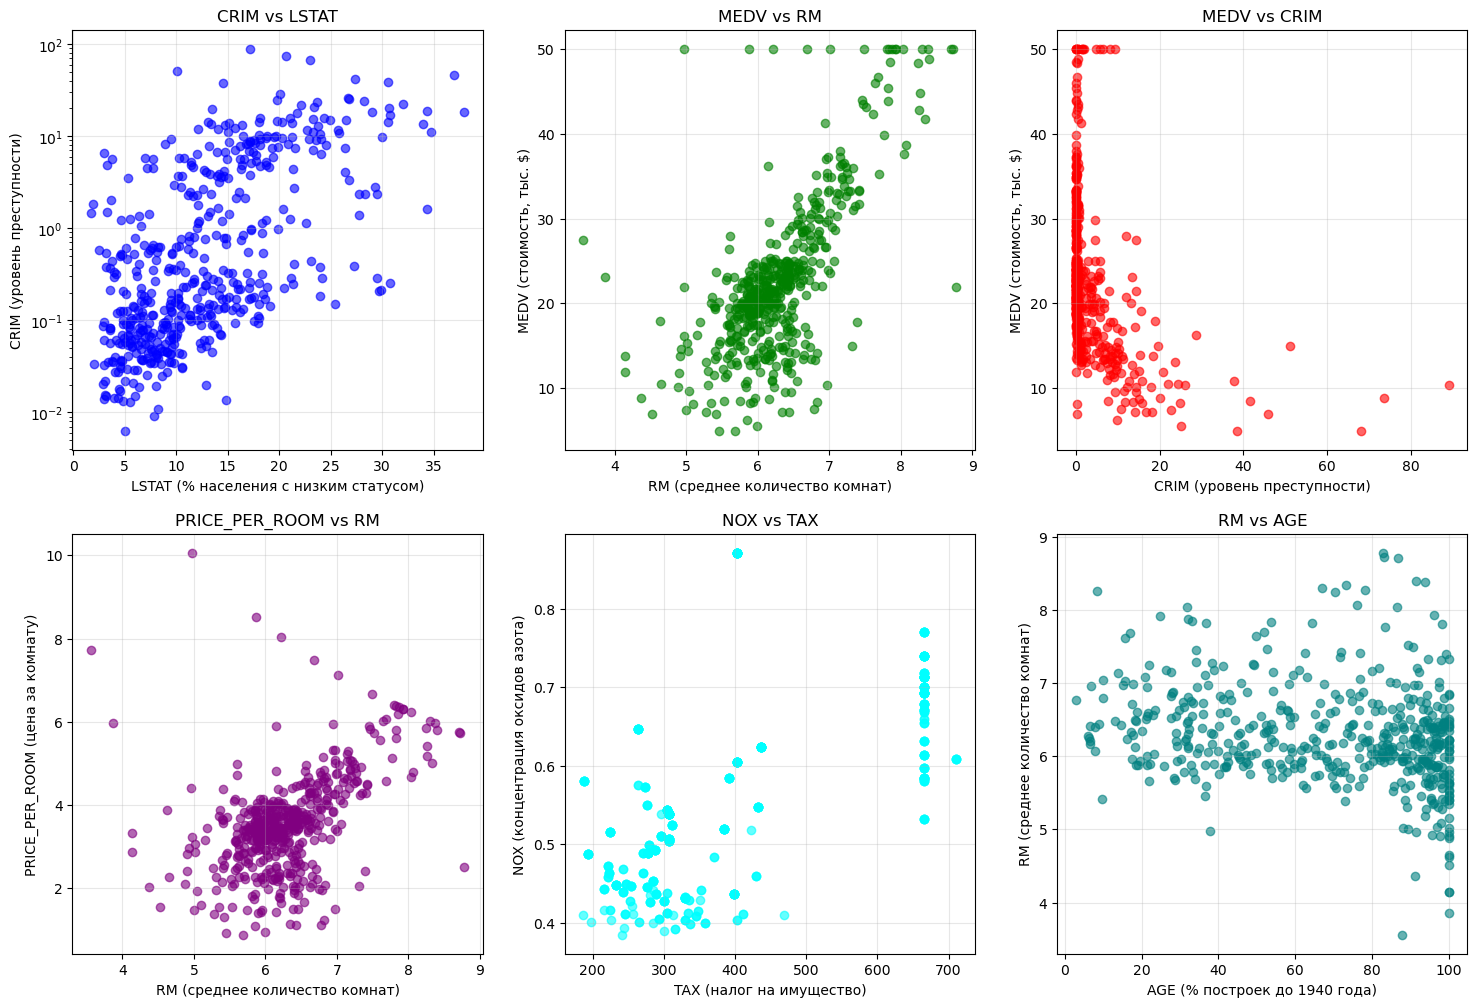

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].scatter(df['LSTAT'], df['CRIM'], alpha=0.6, c='blue')
axes[0, 0].set_xlabel('LSTAT (% населения с низким статусом)')
axes[0, 0].set_ylabel('CRIM (уровень преступности)')
axes[0, 0].set_title('CRIM vs LSTAT')
axes[0, 0].set_yscale('log') 
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(df['RM'], df['MEDV'], alpha=0.6, c='green')
axes[0, 1].set_xlabel('RM (среднее количество комнат)')
axes[0, 1].set_ylabel('MEDV (стоимость, тыс. $)')
axes[0, 1].set_title('MEDV vs RM')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].scatter(df['CRIM'], df['MEDV'], alpha=0.6, c='red')
axes[0, 2].set_xlabel('CRIM (уровень преступности)')
axes[0, 2].set_ylabel('MEDV (стоимость, тыс. $)')
axes[0, 2].set_title('MEDV vs CRIM')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].scatter(df['RM'], df['PRICE_PER_ROOM'], alpha=0.6, c='purple')
axes[1, 0].set_xlabel('RM (среднее количество комнат)')
axes[1, 0].set_ylabel('PRICE_PER_ROOM (цена за комнату)')
axes[1, 0].set_title('PRICE_PER_ROOM vs RM')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['TAX'], df['NOX'], alpha=0.6, c='cyan')
axes[1, 1].set_xlabel('TAX (налог на имущество)')
axes[1, 1].set_ylabel('NOX (концентрация оксидов азота)')
axes[1, 1].set_title('NOX vs TAX')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].scatter(df['AGE'], df['RM'], alpha=0.6, c='teal')
axes[1, 2].set_xlabel('AGE (% построек до 1940 года)')
axes[1, 2].set_ylabel('RM (среднее количество комнат)')
axes[1, 2].set_title('RM vs AGE')
axes[1, 2].grid(True, alpha=0.3)





# Групповой анализ рынка недвижимости Бостона

На основе анализа графиков зависимости между переменными Boston Housing Dataset выделено 4 основные группы, характеризующие сегменты рынка недвижимости.

##  Группа 1: "Элитное жилье"

### Характеристики:
- **Высокая стоимость:** MEDV > 30 тыс. $
- **Просторное жилье:** RM > 7 комнат
- **Благополучное население:** LSTAT < 10%
- **Хорошая экология:** NOX < 0.5
- **Низкая промышленная нагрузка:** INDUS < 5%

### Вывод:
Это престижные районы с максимальным уровнем комфорта и качества жизни. Высокая стоимость обусловлена комплексом преимуществ - от физических характеристик жилья (просторные комнаты) до социального статуса района и благоприятной экологической обстановки. Такие районы привлекают наиболее обеспеченные слои населения.

##  Группа 2: "Средний класс"

### Характеристики:
- **Средняя стоимость:** MEDV 20-30 тыс. $
- **Стандартное жилье:** 6-7 комнат
- **Смешанное население:** LSTAT 10-20%
- **Умеренная удаленность:** DIS 2-5 усл. ед.
- **Переменная экология:** NOX 0.5-0.7

### Вывод:
Наиболее многочисленная и стабильная группа, представляющая стандартное качественное жилье для среднего класса. Районы демонстрируют сбалансированные показатели по всем параметрам - нет явных преимуществ элитных районов, но и отсутствуют серьезные недостатки депрессивных зон. Идеальный баланс цены и качества.

##  Группа 3: "Бюджетное жилье"

### Характеристики:
- **Низкая стоимость:** MEDV < 20 тыс. $
- **Тесное жилье:** RM < 6 комнат
- **Неблагополучное население:** LSTAT > 20%
- **Высокое загрязнение:** NOX > 0.6
- **Высокая промышленная нагрузка:** INDUS > 15%

### Вывод:
Депрессивные районы с комплексом социальных и экологических проблем. Низкая стоимость обусловлена накоплением негативных факторов - тесное жилье, неблагополучное социальное окружение, плохая экология и высокая промышленная нагрузка. Эти районы характеризуются высокой концентрацией социально уязвимых групп населения.

##  Группа 4: "Премиум-локации"

### Характеристики:
- **Эксклюзивная стоимость:** MEDV > 35 тыс. $
- **Компактное элитное жилье:** RM 6-7 комнат
- **Исключительный статус:** LSTAT < 5%
- **Лучшая локация:** минимальная удаленность от центра
- **Максимальная цена за комнату:** PRICE_PER_ROOM > 7

### Вывод:
Уникальные локации, где стоимость определяется не столько метражом, сколько исключительным расположением и статусом района. Это могут быть исторические центры, районы с особой инфраструктурой, знаменитые улицы или места с уникальной архитектурой. Цена за квадратный метр здесь максимальна, что отражает премиальный характер этих территорий.

##  Общий анализ групп

| Группа | Доля рынка | Ценовой сегмент | Социальный статус |
|---------|------------|-----------------|-------------------|
| Элитное жилье | 10-15% | Премиум | Высокий |
| Средний класс | 40-50% | Средний | Средний |
| Бюджетное жилье | 30-35% | Эконом | Низкий |
| Премиум-локации | 5-10% | Люкс | Элитный |

**Ключевая закономерность:** Наблюдается четкая стратификация рынка недвижимости, где стоимость жилья комплексно определяется физическими характеристиками (количество комнат), социальным составом населения и экологическими условиями района.

## Метод KMeans

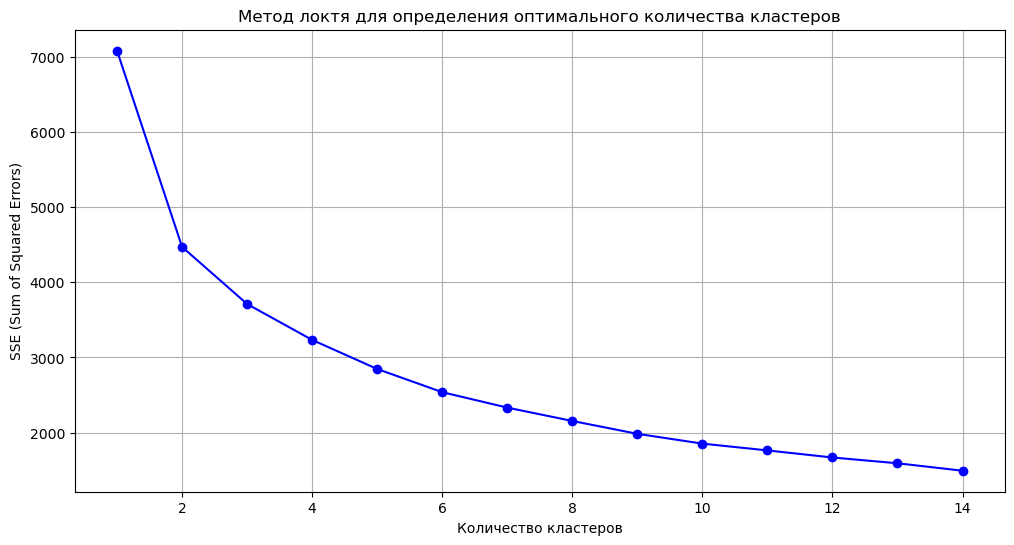

In [20]:

features_for_clustering = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 
                          'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV', 'PRICE_PER_ROOM']

X = df[features_for_clustering].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sse = []
k_range = range(1, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.grid(True)
plt.show()

Как видно из графика оптимальное число кластеров это 4

Распределение объектов по кластерам:
Cluster
0    158
1    214
2     46
3     88
Name: count, dtype: int64


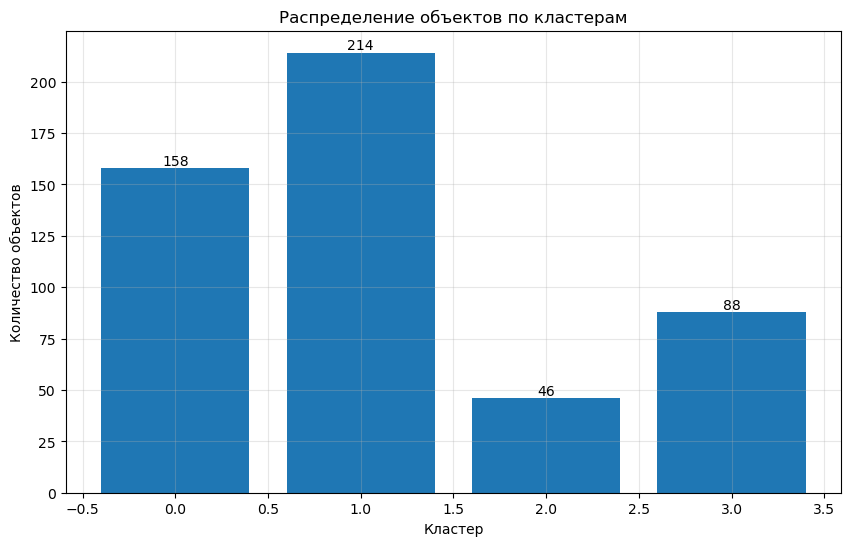

In [30]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df['Cluster'] = cluster_labels

print("Распределение объектов по кластерам:")
cluster_counts = df['Cluster'].value_counts().sort_index()
print(cluster_counts)

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Кластер')
plt.ylabel('Количество объектов')
plt.title('Распределение объектов по кластерам')
for i, count in enumerate(cluster_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.grid(True, alpha=0.3)
plt.show()

**Средние значения признаков по кластерам:**

In [38]:
cluster_analysis = df.groupby('Cluster')[features_for_clustering].mean()
print("Средние значения признаков по кластерам:")
print(cluster_analysis.round(2))

Средние значения признаков по кластерам:
          CRIM     ZN  INDUS   NOX    RM    AGE   DIS    RAD     TAX  PTRATIO  \
Cluster                                                                         
0        10.71   0.00  18.81  0.69  5.95  90.81  2.02  20.17  626.51    19.74   
1         0.35   3.18   9.33  0.51  6.10  66.11  4.04   4.46  309.30    18.55   
2         1.19   6.80   7.40  0.55  7.42  77.95  2.82   7.09  318.15    16.41   
3         0.07  54.05   3.71  0.42  6.73  29.74  6.90   4.15  304.02    16.98   

              B  LSTAT   MEDV  PRICE_PER_ROOM  
Cluster                                        
0        295.29  19.32  15.16            2.57  
1        382.37  11.94  21.31            3.48  
2        385.73   5.58  41.28            5.61  
3        389.21   6.12  28.95            4.25  


## Вывод

На основе проведенного анализа данных о недвижимости Бостона можно сделать вывод, что стоимость жилья тесно связана с социально-экономическими и физическими характеристиками районов. Наибольшее влияние на цену оказывают такие факторы, как процент населения с низким статусом (LSTAT), среднее количество комнат (RM) и уровень преступности (CRIM). Добавленный атрибут PRICE_PER_ROOM позволил более детально оценить стоимость одного жилого помещения, что может быть полезно для более точного прогнозирования и сегментации рынка недвижимости.

Проведенная кластеризация методом k-means с визуализацией средствами PCA показала возможность сегментации районов на несколько однородных групп с характерными признаками. Это подтверждает гипотезу о структурной неоднородности рынка недвижимости Бостона. Полученные результаты могут служить основой для построения прогнозных моделей стоимости жилья и выявления ключевых драйверов ценообразования в городской среде, что представляет практическую ценность для риелторов, девелоперов и градостроителей.